In [1]:
import os
import random
from datetime import datetime
import pandas as pd
import numpy as np
import time

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import uuid


c:\Python3.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)

In [3]:
torch.cuda.is_available()

True

In [37]:
images_path = Path("Projects/Road-Sign-Detection/images")
anno_path = Path("Projects/Road-Sign-Detection/annotations")

In [38]:
prat_images_path = Path("Projects/prathmesh_dataset/train")
prat_anno_path = Path("Projects/prathmesh_dataset/xml")

Opening images and annotation files and creating a pandas dataframe

In [39]:
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [40]:
def generate_prat_train_df(prat_anno_path):
    annotations = filelist(prat_anno_path, '.xml')
    anno_list = []

    for prat_anno_path in annotations:
        root = ET.parse(prat_anno_path).getroot()
        anno = {}

        # Extracting information based on the new XML format
        for row in root.findall('.//row'):
            anno['filename'] = Path(row.find('./filename').text)
            anno['width'] = int(row.find('./width').text)
            anno['height'] = int(row.find('./height').text)
            anno['class'] = row.find('./class').text
            anno['xmin'] = int(row.find('./xmin').text)
            anno['ymin'] = int(row.find('./ymin').text)
            anno['xmax'] = int(row.find('./xmax').text)
            anno['ymax'] = int(row.find('./ymax').text)
            anno_list.append(anno)

    return pd.DataFrame(anno_list)


In [41]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,267,400,trafficlight,98,62,208,232
1,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,283,trafficlight,154,63,258,281
2,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,267,trafficlight,106,3,244,263
3,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,385,speedlimit,35,5,363,326
4,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,300,400,stop,90,101,268,257
873,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,267,stop,209,58,326,179
874,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,267,stop,42,66,130,154
875,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,267,stop,138,17,376,245


In [42]:
df_train_prat = generate_prat_train_df(prat_anno_path)

# Replace 'Speedlimit' with 'speedlimit' in the 'class' column
df_train_prat['class'] = df_train_prat['class'].replace({'Speedlimit': 'speedlimit'})
df_train_prat

,filename,width,height,class,xmin,ymin,xmax,ymax
0,road1000_jpg.rf.0dc5271e50c74569094244375e67bd...,640,640,railroad,330,13,444,202
1,road1000_jpg.rf.2f7264347c38a4939b0e8b4615606e...,640,640,railroad,309,12,387,188
2,road1000_jpg.rf.cdab4d62b41874662fe718343a35f3...,640,640,railroad,314,24,406,207
3,road1001_jpg.rf.9bb898cd4d5397da9ea7d6e0742909...,640,640,railroad,303,85,386,268
4,road1001_jpg.rf.ec0f6ffaf63d4ea6ad27d26364cf82...,640,640,railroad,250,69,386,269
...,...,...,...,...,...,...,...,...
349,road998_jpg.rf.c053d6105004f215eb09c38fa4c7ba8...,640,640,railroad,408,45,635,444
350,road998_jpg.rf.e4c51636995338cad4d7db35d229d71...,640,640,railroad,414,24,611,411
351,road999_jpg.rf.13b69927b162693631daa12d9f7e627...,640,640,railroad,379,323,604,484
352,road999_jpg.rf.9cf9bb9349935344eca49695958c1ed...,640,640,railroad,340,341,596,550


In [43]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [44]:
df_train_prat['class'].value_counts()

warning       111
railroad       93
roadwork       75
speedlimit     75
Name: class, dtype: int64

Assigning values to classes for the kaggle data

In [45]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,267,400,3,98,62,208,232
1,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,283,3,154,63,258,281
2,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,267,3,106,3,244,263
3,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,385,0,35,5,363,326
4,C:\Users\Rishit Thakkar\OneDrive\Desktop\Colum...,400,200,0,195,7,392,194


Assigning values to classes for collected data

In [46]:
class_dict_prat = {'speedlimit': 0, 'warning': 4, 'railroad': 5, 'roadwork': 6}
df_train_prat['class'] = df_train_prat['class'].apply(lambda x:  class_dict_prat[x])

print(df_train_prat.shape)
df_train_prat.head()

(354, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road1000_jpg.rf.0dc5271e50c74569094244375e67bd...,640,640,5,330,13,444,202
1,road1000_jpg.rf.2f7264347c38a4939b0e8b4615606e...,640,640,5,309,12,387,188
2,road1000_jpg.rf.cdab4d62b41874662fe718343a35f3...,640,640,5,314,24,406,207
3,road1001_jpg.rf.9bb898cd4d5397da9ea7d6e0742909...,640,640,5,303,85,386,268
4,road1001_jpg.rf.ec0f6ffaf63d4ea6ad27d26364cf82...,640,640,5,250,69,386,269


Cropping the images according to the bounding box values and saving it in a new folder for both the datasets

In [47]:
# Function to read and crop images
def crop_and_save_images(df, images_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for index, row in df.iterrows():
        image_path = str(row['filename'])
        img = cv2.imread(image_path)
        
        # Get bounding box coordinates
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        # Crop the image
        cropped_img = img[ymin:ymax, xmin:xmax, :]
        
        # Get the label
        label = row['class']
        
        # Save the cropped image with the label as filename
        output_path = os.path.join(output_folder, f"label_{label}")
        os.makedirs(output_path, exist_ok=True)
        output_filename = f"{label}_{index}.png"
        output_filepath = os.path.join(output_path, output_filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

output_folder = "Projects/Road-Sign-Detection/cropped_images"

# Crop and save all images
crop_and_save_images(df_train, images_path, output_folder)

In [48]:
def crop_and_save_images_prat(df, prat_images_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for index, row in df.iterrows():  
        image_filename = str(row['filename'])
        image_path = os.path.join(prat_images_path, image_filename)  
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Failed to read image: {image_path}")
                continue
        except Exception as e:
            print(f"Error reading image: {image_path}")
            print(f"Exception: {e}")
            continue

        # Get bounding box coordinates
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        # Crop the image
        cropped_img = img[ymin:ymax, xmin:xmax, :]
        
        # Get the label
        label = row['class']
        
        # Save the cropped image with the label as filename
        output_path = os.path.join(output_folder, f"label_{label}")
        os.makedirs(output_path, exist_ok=True)
        output_filename = f"{label}_{index}.png"
        output_filepath = os.path.join(output_path, output_filename)
        cv2.imwrite(output_filepath, cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

prat_images_path = "Projects/prathmesh_dataset/train"
output_folder_prat = "Projects/prathmesh_dataset/cropped_images"
crop_and_save_images_prat(df_train_prat, prat_images_path, output_folder_prat)

Resizing the images according to the LeNET architechture for both the dataset

In [49]:
# Function to resize images in a folder
def resize_images_in_folder(input_folder, output_folder, target_size=(224, 224)):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            
            # Read and resize the image
            img = cv2.imread(input_path)
            resized_img = cv2.resize(img, target_size)
            
            # Save the resized image
            cv2.imwrite(output_path, cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))

label0_folder = "Projects/Road-Sign-Detection/cropped_images/label_0"
output_folder_label0 = "Projects/Road-Sign-Detection/cropped_resized_images/label_0"

label1_folder = "Projects/Road-Sign-Detection/cropped_images/label_1"
output_folder_label1 = "Projects/Road-Sign-Detection/cropped_resized_images/label_1"

label2_folder = "Projects/Road-Sign-Detection/cropped_images/label_2"
output_folder_label2 = "Projects/Road-Sign-Detection/cropped_resized_images/label_2"

label3_folder = "Projects/Road-Sign-Detection/cropped_images/label_3"
output_folder_label3 = "Projects/Road-Sign-Detection/cropped_resized_images/label_3"

# Resize images in the input folder and save in the output folder
resize_images_in_folder(label0_folder, output_folder_label0, target_size=(224, 224))
resize_images_in_folder(label1_folder, output_folder_label1, target_size=(224, 224))
resize_images_in_folder(label2_folder, output_folder_label2, target_size=(224, 224))
resize_images_in_folder(label3_folder, output_folder_label3, target_size=(224, 224))

In [50]:
# Function to resize images in a folder
def resize_images_in_folder_prat(input_folder, output_folder, target_size=(224, 224)):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            unique_suffix = str(uuid.uuid4())[:8]

            output_filename = f"{filename.split('.')[0]}_{unique_suffix}.png"
            output_path = os.path.join(output_folder, output_filename)

            if os.path.exists(output_path):
                print(f"Skipped existing file: {output_path}")
                continue
            
            # Read and resize the image
            img = cv2.imread(input_path)
            resized_img = cv2.resize(img, target_size)
            
            # Save the resized image
            cv2.imwrite(output_path, cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))

label0_folder = "Projects/prathmesh_dataset/cropped_images/label_0"
output_folder_label0 = "Projects/Road-Sign-Detection/cropped_resized_images/label_0"

label4_folder = "Projects/prathmesh_dataset/cropped_images/label_4"
output_folder_label4 = "Projects/Road-Sign-Detection/cropped_resized_images/label_4"

label5_folder = "Projects/prathmesh_dataset/cropped_images/label_5"
output_folder_label5 = "Projects/Road-Sign-Detection/cropped_resized_images/label_5"

label6_folder = "Projects/prathmesh_dataset/cropped_images/label_6"
output_folder_label6 = "Projects/Road-Sign-Detection/cropped_resized_images/label_6"

# Resize images in the input folder and save in the output folder
resize_images_in_folder_prat(label0_folder, output_folder_label0, target_size=(224, 224))
resize_images_in_folder_prat(label4_folder, output_folder_label4, target_size=(224, 224))
resize_images_in_folder_prat(label5_folder, output_folder_label5, target_size=(224, 224))
resize_images_in_folder_prat(label6_folder, output_folder_label6, target_size=(224, 224))

Train, val, and test split with uniformity, by using stratify split

In [51]:
from sklearn.model_selection import train_test_split

# Specify the ratio for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Create lists to store image paths for each label
label0_images = [os.path.join(output_folder_label0, filename) for filename in os.listdir(output_folder_label0)]
label1_images = [os.path.join(output_folder_label1, filename) for filename in os.listdir(output_folder_label1)]
label2_images = [os.path.join(output_folder_label2, filename) for filename in os.listdir(output_folder_label2)]
label3_images = [os.path.join(output_folder_label3, filename) for filename in os.listdir(output_folder_label3)]
label4_images = [os.path.join(output_folder_label4, filename) for filename in os.listdir(output_folder_label4)]
label5_images = [os.path.join(output_folder_label5, filename) for filename in os.listdir(output_folder_label5)]
label6_images = [os.path.join(output_folder_label6, filename) for filename in os.listdir(output_folder_label6)]

# Combine image paths and labels into tuples for each label
data_label0 = list(zip(label0_images, [0] * len(label0_images)))
data_label1 = list(zip(label1_images, [1] * len(label1_images)))
data_label2 = list(zip(label2_images, [2] * len(label2_images)))
data_label3 = list(zip(label3_images, [3] * len(label3_images)))
data_label4 = list(zip(label4_images, [4] * len(label4_images)))
data_label5 = list(zip(label5_images, [5] * len(label5_images)))
data_label6 = list(zip(label6_images, [6] * len(label6_images)))

train_data_label0, test_val_data_label0 = train_test_split(data_label0, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[0] * len(data_label0))
test_data_label0, val_data_label0 = train_test_split(test_val_data_label0, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[0] * len(test_val_data_label0))

train_data_label1, test_val_data_label1 = train_test_split(data_label1, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[1] * len(data_label1))
test_data_label1, val_data_label1 = train_test_split(test_val_data_label1, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[1] * len(test_val_data_label1))

train_data_label2, test_val_data_label2 = train_test_split(data_label2, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[2] * len(data_label2))
test_data_label2, val_data_label2 = train_test_split(test_val_data_label2, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[2] * len(test_val_data_label2))

train_data_label3, test_val_data_label3 = train_test_split(data_label3, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[3] * len(data_label3))
test_data_label3, val_data_label3 = train_test_split(test_val_data_label3, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[3] * len(test_val_data_label3))

train_data_label4, test_val_data_label4 = train_test_split(data_label4, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[4] * len(data_label4))
test_data_label4, val_data_label4 = train_test_split(test_val_data_label4, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[4] * len(test_val_data_label4))

train_data_label5, test_val_data_label5 = train_test_split(data_label5, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[5] * len(data_label5))
test_data_label5, val_data_label5 = train_test_split(test_val_data_label5, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[5] * len(test_val_data_label5))

train_data_label6, test_val_data_label6 = train_test_split(data_label6, test_size=test_ratio+val_ratio, random_state=random_seed, stratify=[6] * len(data_label6))
test_data_label6, val_data_label6 = train_test_split(test_val_data_label6, test_size=val_ratio/(test_ratio+val_ratio), random_state=random_seed, stratify=[6] * len(test_val_data_label6))


train_set = train_data_label0 + train_data_label1 + train_data_label2 + train_data_label3 + train_data_label4 + train_data_label5 + train_data_label6
test_set = test_data_label0 + test_data_label1 + test_data_label2 + test_data_label3 + test_data_label4 + test_data_label5 + test_data_label6
val_set = val_data_label0 + val_data_label1 + val_data_label2 + val_data_label3 + val_data_label4 + val_data_label5 + val_data_label6


# Shuffle the data
train_set = shuffle(train_set, random_state=random_seed)
test_set = shuffle(test_set, random_state=random_seed)
val_set = shuffle(val_set, random_state=random_seed)

# Unzip the shuffled data to get the final sets
train_set, labels_train = zip(*train_set)
test_set, labels_test = zip(*test_set)
val_set, labels_val = zip(*val_set)

# Print the number of images in each set
print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Validation set size: {len(val_set)}")

Train set size: 858
Test set size: 184
Validation set size: 189


Checking Stratify split functionality, by counting the images from each class in the train, test and validation sets

In [52]:
from collections import Counter

# Count occurrences of each label in the training set
train_label_counts = Counter(labels_train)

# Count occurrences of each label in the testing set
test_label_counts = Counter(labels_test)

# Count occurrences of each label in the validation set
val_label_counts = Counter(labels_val)

# Print the counts for each set
print("Train set label counts:", train_label_counts)
print("Test set label counts:", test_label_counts)
print("Validation set label counts:", val_label_counts)


Train set label counts: Counter({0: 508, 4: 77, 5: 65, 2: 61, 1: 53, 6: 52, 3: 42})
Test set label counts: Counter({0: 109, 4: 17, 5: 14, 2: 13, 1: 11, 6: 11, 3: 9})
Validation set label counts: Counter({0: 110, 4: 17, 5: 14, 2: 14, 6: 12, 1: 12, 3: 10})


Displaying random images from the testset with its label for checking purpose

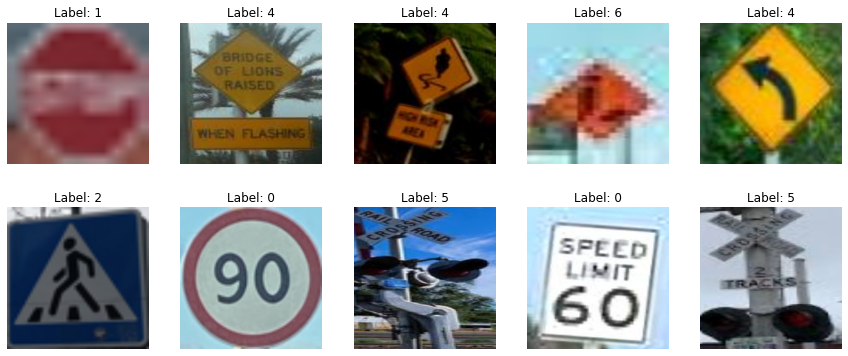

In [59]:
def display_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3)

    for i, ax in enumerate(axes.flat):
        img_path = images[i]
        label = labels[i]

        # Load and display the image
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.show()

# Display 10 random images with aligned labels
random_indices = random.sample(range(len(train_set)), 10)
random_images = [train_set[i] for i in random_indices]
random_labels = [labels_train[i] for i in random_indices]

display_images(random_images, random_labels)

LeNET Model Defination

In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1_size = 64 * 53 * 53  
        self.fc1 = nn.Linear(self.fc1_size, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1_size)  
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.fc2(x)
        return x


Creating dataloaders 

In [61]:

# Convert images to PyTorch tensors
train_images_tensor = torch.stack([torchvision.transforms.ToTensor()(Image.open(img_path)) for img_path in train_set])
train_labels_tensor = torch.tensor(labels_train)

# Create a custom dataset
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)

# Create DataLoader for training set
train_batch_size = 32  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Convert validation images to PyTorch tensors
val_images_tensor = torch.stack([torchvision.transforms.ToTensor()(Image.open(img_path)) for img_path in val_set])
val_labels_tensor = torch.tensor(labels_val)

# Create a custom validation dataset
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Create DataLoader for validation set
val_batch_size = 32  # Choose an appropriate batch size for validation
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

# Convert test images to PyTorch tensors
test_images_tensor = torch.stack([torchvision.transforms.ToTensor()(Image.open(img_path)) for img_path in test_set])
test_labels_tensor = torch.tensor(labels_test)

# Create a custom test dataset
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Create DataLoader for the test set
test_batch_size = 32  # Choose an appropriate batch size
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet()  
model.to(device)

# Define criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

Model Training, validation, saving and testing

Epoch 1/15, Train Loss: 1.6086, Train Accuracy: 0.5420, Validation Loss: 1.3729, Validation Accuracy: 0.5820
Model saved at epoch 1
Epoch 2/15, Train Loss: 1.3237, Train Accuracy: 0.5921, Validation Loss: 1.2697, Validation Accuracy: 0.5820
Epoch 3/15, Train Loss: 1.2072, Train Accuracy: 0.5921, Validation Loss: 1.1156, Validation Accuracy: 0.5873
Model saved at epoch 3
Epoch 4/15, Train Loss: 1.0341, Train Accuracy: 0.6247, Validation Loss: 0.8941, Validation Accuracy: 0.6455
Model saved at epoch 4
Epoch 5/15, Train Loss: 0.8170, Train Accuracy: 0.7296, Validation Loss: 0.6605, Validation Accuracy: 0.8201
Model saved at epoch 5
Epoch 6/15, Train Loss: 0.6517, Train Accuracy: 0.7972, Validation Loss: 0.5562, Validation Accuracy: 0.8730
Model saved at epoch 6
Epoch 7/15, Train Loss: 0.5467, Train Accuracy: 0.8240, Validation Loss: 0.4900, Validation Accuracy: 0.8413
Epoch 8/15, Train Loss: 0.4741, Train Accuracy: 0.8531, Validation Loss: 0.3824, Validation Accuracy: 0.9101
Model saved a

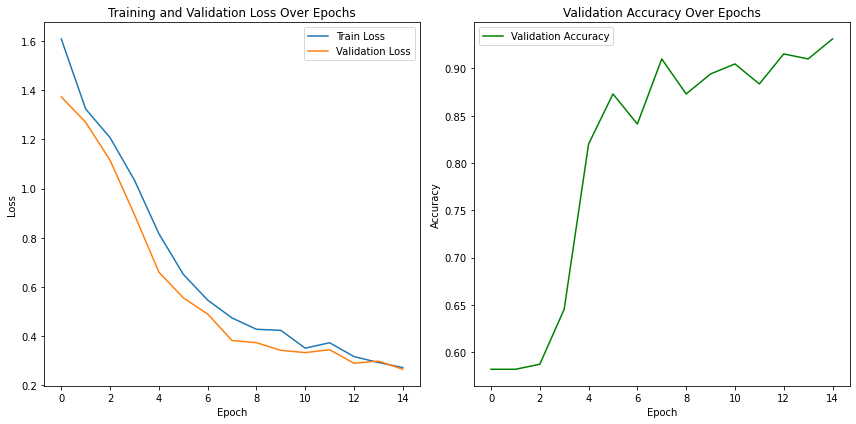

Test Loss: 0.1751, Test Accuracy: 0.9348


In [63]:
# Training and validation loop with early stopping
num_epochs = 15
accumulation_steps = 2  # Accumulate gradients over 2 batches before updating weights
best_val_accuracy = 0.0
# best_model_state_dict = None
train_losses = []
val_losses = []
val_accuracies = []  

early_stopping_patience = 10
early_stopping_counter = 0

train_batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

best_model_path = "Projects/Road-Sign-Detection/best_model.pth"

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = correct_predictions / total_samples
    average_train_loss = running_loss / (batch_idx + 1)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        average_val_loss = val_loss / len(val_loader)

        # Append losses for plotting
        train_losses.append(average_train_loss)
        val_losses.append(average_val_loss)

        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # best_model_state_dict = model.state_dict()
            torch.save(model, best_model_path)
            print(f"Model saved at epoch {epoch+1}")
            early_stopping_counter = 0  # Reset the counter if there's an improvement
        else:
            early_stopping_counter += 1  # Increment the counter if there's no improvement

        # Check for early stopping
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Testing loop
model = torch.load(best_model_path)  # Load the best model for testing
model.to(device)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
average_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Displaying predicted and original labels on the testing images

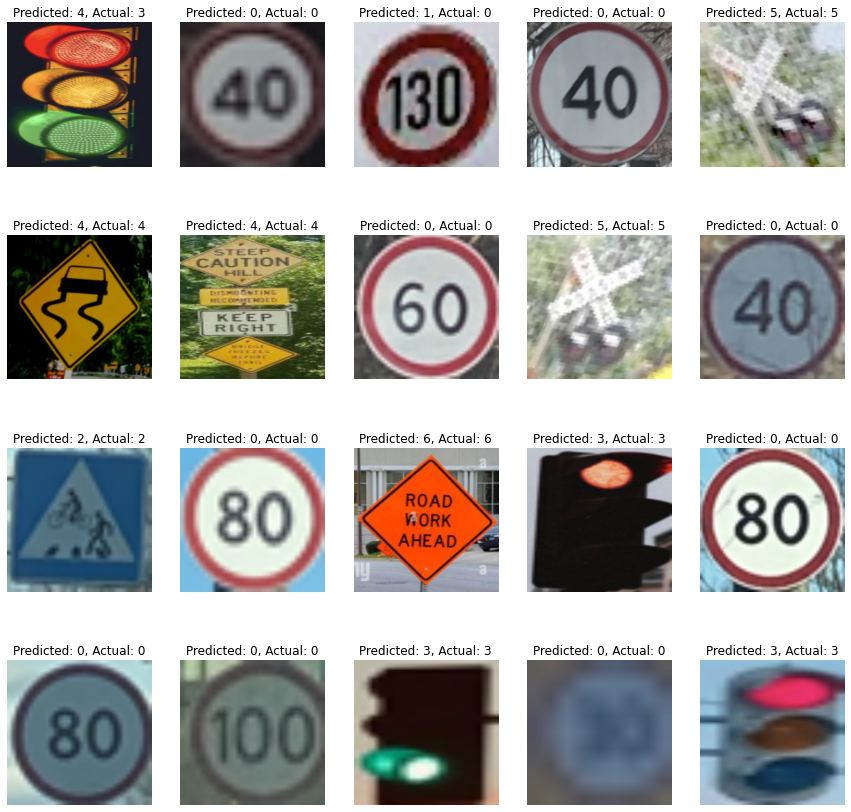

In [64]:
# Define a function to display images in a grid
def display_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i].permute(1, 2, 0))
            ax.set_title(titles[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

# Show 20 random images from the testing set with predicted labels
num_images_to_show = 20
random_indices = random.sample(range(len(test_dataset)), num_images_to_show)

# Lists to store images and titles
display_images_list = []
display_titles_list = []

for idx in random_indices:
    with torch.no_grad():
        inputs, labels = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append image and title to the lists
        display_images_list.append(inputs.cpu().squeeze())
        display_titles_list.append(f"Predicted: {predicted.item()}, Actual: {labels}")

# Display images in a grid with 5 images per row
num_images = len(display_images_list)
rows = (num_images + 4) // 5  # Ensure there are at least 5 images per row

display_images(display_images_list, display_titles_list, rows, 5)

Class-wise accuracy

In [65]:
# Initialize counters for each class
num_classes = 7
class_correct = [0] * num_classes
class_total = [0] * num_classes

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Update counters for each class
        for i in range(num_classes):
            class_total[i] += (labels == i).sum().item()
            class_correct[i] += (predicted == labels)[labels == i].sum().item()

# Display results
for i in range(num_classes):
    accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"Class {i}: Total Images={class_total[i]}, Correct Predictions={class_correct[i]}, Accuracy={accuracy:.4f}")


Class 0: Total Images=109, Correct Predictions=107, Accuracy=0.9817
Class 1: Total Images=11, Correct Predictions=11, Accuracy=1.0000
Class 2: Total Images=13, Correct Predictions=12, Accuracy=0.9231
Class 3: Total Images=9, Correct Predictions=6, Accuracy=0.6667
Class 4: Total Images=17, Correct Predictions=13, Accuracy=0.7647
Class 5: Total Images=14, Correct Predictions=13, Accuracy=0.9286
Class 6: Total Images=11, Correct Predictions=10, Accuracy=0.9091


Testing the classification model on an image taken from google

In [66]:
model1 = LeNet()
model1=(torch.load(best_model_path))
model1.to(device)
model1.eval()


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
image_path = "Projects/stop3.png"
input_image = Image.open(image_path).convert('RGB')
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model1(input_batch)

_, predicted_class = torch.max(output, 1)

class_index_to_label = {0: 'speedlimit', 1: 'stop', 2: 'crosswalk', 3: 'trafficlight', 4: 'warning', 5: 'railroad', 6: 'roadwork'}

# Print raw output and predicted class for debugging
print("Raw output:", output)
print("Predicted class index:", predicted_class.item())

# Ensure that the predicted class index exists in the mapping
if predicted_class.item() in class_index_to_label:
    predicted_label = class_index_to_label[predicted_class.item()]
    print("Predicted label:", predicted_label)
else:
    print("Error: Predicted class index not found in the mapping.")

Raw output: tensor([[ -4.7463,  26.6108, -10.5161,   4.2511,  -4.7781,  -4.1128,  -3.7616]],
       device='cuda:0')
Predicted class index: 1
Predicted label: stop
